In [5]:
#TO RE-RUN
%reset -f

In [6]:
from sklearn import preprocessing
from time import time
import numpy as np
import csv
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.feature_selection import VarianceThreshold
from sklearn.cross_validation import StratifiedShuffleSplit

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline


from sklearn.metrics import pairwise_distances
from IPython.display import display, HTML
from operator import truediv
import pandas as pd
import time
import os

from pylab import *
import seaborn as sns
import matplotlib.pyplot as plt


np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:,.3f}'.format
plt.style.use('classic')

%matplotlib inline

import sys
sys.path.insert(1, "../src/")
from TypeFeatImputer import TypeFeatImputer

In [15]:
typeEncounter = "last" # ['first','last']
typeHypothesis = "early_readmission_vs_none" # ['all_readmisssion_vs_none','early_readmission_vs_none']
typeDataFeatures = "extended_extra" # ["non_extended","extended','extended_extra'] 
typeDiagnosis = "diag_1"  #["none","diag_1", "diag_3"]    
typeDataExperiment = "disease" #["all", "disease"] 
    #all -> Include all diagnosis as columns
    #disease -> Remove diagnosis as column and keep only rows with diagnosis == 1 

In [17]:
if typeDataFeatures == "non_extended":
    df_all=pd.read_pickle(os.path.join('resources','prepared_clean_data_' + typeEncounter + "_" +  typeDiagnosis + '.pkl'))
else:
    df_all=pd.read_pickle(os.path.join('resources','prepared_clean_data_' + typeEncounter + "_" +  typeDiagnosis + '_' + typeDataFeatures + '.pkl'))

print df_all.shape

(67182, 69)


In [18]:
# Readmitted none vs readmitted
if typeHypothesis == "all_readmisssion_vs_none":
    df_all["readmitted"][df_all["readmitted"].values > 0] = 1

# Readmitted none vs early readmitted            
if typeHypothesis == "early_readmission_vs_none":
    df_all= df_all[df_all["readmitted"].isin([0,1])]
    
print df_all.shape

(45779, 69)


#### Inspect null values

,%_Null,#_Null,#_No_Null
gender,0.000,3,45776


(1, 3)


<function matplotlib.pyplot.show>

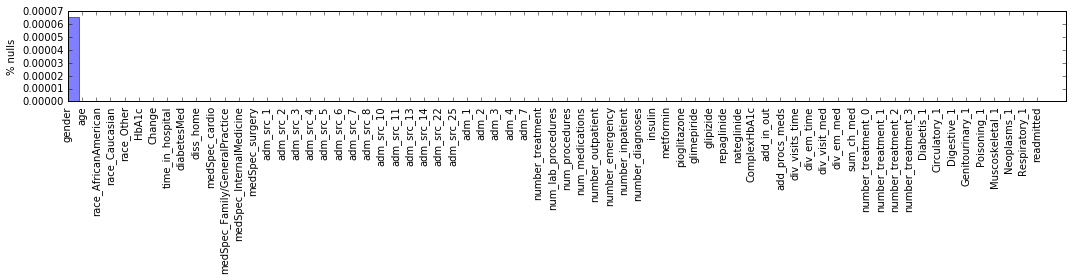

In [19]:
dfNull = np.sum(df_all.isnull()) / float(df_all.shape[0])
dfNullAll = pd.concat([dfNull[dfNull>0],np.sum(df_all.isnull()),np.sum(df_all.isnull()==False)], axis=1)
dfNullAll.columns= ["%_Null","#_Null","#_No_Null"]

display(dfNullAll[dfNullAll.iloc[:,0].isnull() == False][["%_Null","#_Null","#_No_Null"]])
print dfNullAll[dfNullAll.iloc[:,0].isnull() == False].shape


plt.figure(figsize=(15,4))
plt.bar(range(dfNull.shape[0]),dfNull.iloc[:], alpha=0.5)
plt.xticks(range(dfNull.shape[0]),dfNull.index,rotation=90)
plt.ylabel("% nulls")
plt.tight_layout()
plt.show

#### Find categorical features

In [20]:
#Compute type fields
    
numCols = ['time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 
            'number_emergency', 'number_inpatient', 'number_diagnoses',
            'add_in_out', 'add_procs_meds', 'div_visits_time', 'div_em_time', 'div_visit_med', 'div_em_med',
            'number_treatment','number_treatment_0','number_treatment_1','number_treatment_2','number_treatment_3']


catCols = []
cols = df_all.columns
reducedCols = df_all.columns[:-1]

for i in range(len(cols)):
    if cols[i] not in numCols:
        catCols.append(1)
    else:
        catCols.append(0)
catCols = np.array(catCols)

print "Cat cols:", np.sum(catCols==1)
print "Num cols:", np.sum(catCols==0)
print len(reducedCols)
print len(cols)

Cat cols: 50
Num cols: 19
68
69


#### Identify categorical features with less 5% values

In [26]:
total = 0
minFreq = df_all.shape[0] * 0.005


print "MAX=", df_all.shape[0], "MIN:", minFreq
for c in df_all.columns[catCols == 1]:
    num = np.min(pd.value_counts(df_all[c]))
    if num < minFreq:
        total += 1
        print
        print len(df_all[c].unique()), df_all[c].unique().tolist()
        print pd.value_counts(df_all[c]).sort_values(0)

print "total low variance features:", total

MAX= 45779 MIN: 228.895

10 [5, 8, 3, 6, 7, 4, 9, 2, 1, 0]
0      120
1      377
2      825
9     1282
3     1910
4     4646
8     7091
5     8212
6    10248
7    11068
Name: age, dtype: int64

2 [0L, 1L]
1       57
0    45722
Name: adm_src_3, dtype: int64

2 [0L, 1L]
1       10
0    45769
Name: adm_src_8, dtype: int64

2 [0L, 1L]
1        5
0    45774
Name: adm_src_10, dtype: int64

2 [0L, 1L]
1        1
0    45778
Name: adm_src_11, dtype: int64

2 [0L, 1L]
1        1
0    45778
Name: adm_src_13, dtype: int64

2 [0L, 1L]
1        2
0    45777
Name: adm_src_14, dtype: int64

2 [0L, 1L]
1        4
0    45775
Name: adm_src_22, dtype: int64

2 [0L, 1L]
1        2
0    45777
Name: adm_src_25, dtype: int64

2 [0L, 1L]
1        7
0    45772
Name: adm_4, dtype: int64

2 [0L, 1L]
1       18
0    45761
Name: adm_7, dtype: int64

4 [0, 2, 3, 1]
1       40
3      110
2     3202
0    42427
Name: pioglitazone, dtype: int64

4 [0, 2, 1, 3]
1       91
3      148
2     2203
0    43337
Name: glimepirid

#### Data Exploration

Categorical

In [27]:
from sklearn.feature_selection import chi2

for cond in ["non_all", "non_early"]:
    
    if cond == "non_all":
        dfFilteredAux = df_all.copy()
        classVal = dfFilteredAux["readmitted"]>0
    else:
        dfFilteredAux = df_all[df_all["readmitted"]<=1].copy()
        classVal = dfFilteredAux["readmitted"]>0
        
    catData = []    
    for rv in dfFilteredAux.columns[catCols == 1]:

        cleanIc = dfFilteredAux[rv]

        #Null policy (drop)
        ix = cleanIc.dropna().index

        #Get readmitted
        #valClass = dfFiltered["readmitted"]>0        
        r, p = chi2(cleanIc.dropna().values.astype(int).reshape(-1,1),classVal[ix].astype(int).reshape(-1,1))    

        perc = (pd.value_counts(dfFilteredAux[dfFilteredAux["readmitted"] == 0][rv])/dfFilteredAux[dfFilteredAux["readmitted"] == 0][rv].count()).round(3).values.tolist()
        perc_1 = (pd.value_counts(dfFilteredAux[dfFilteredAux["readmitted"] > 0][rv])/dfFilteredAux[dfFilteredAux["readmitted"] > 0][rv].count()).round(3).values.tolist()
        catData.append([str(rv),
                        np.sum(cleanIc.isnull() == False),
                        np.sum(cleanIc.isnull() == True),
                        np.sum(cleanIc.isnull()) / float(len(cleanIc)),
                        pd.value_counts(cleanIc).index.astype(int).tolist(), 
                        pd.value_counts(cleanIc).values.tolist(),
                        str(pd.value_counts(dfFilteredAux[dfFilteredAux["readmitted"] == 0][rv]).values.tolist()),
                        str(perc),
                        str(pd.value_counts(dfFilteredAux[dfFilteredAux["readmitted"] > 0][rv]).values.tolist()),
                        str(perc_1),                    
                        abs(perc_1[0] - perc[0]),
                        round(p,4),
                        "yes" if p<0.05 else "no"
                        ])

    dfCatData = pd.DataFrame(catData, columns=["variable","num","#nulls",u"%nulls","values","frequencies",
                                               "non-readmitted (n)","non-readmitted (%)",
                                               "readmitted (n)" if cond == "non_all" else "early_readmitted (n)",
                                               "readmitted (%)" if cond == "non_all" else "early_readmitted (%)",
                                               "diff (%)",
                                               "p-value","sig."])
    print dfCatData[dfCatData["p-value"] < 0.05].shape
    display(HTML(dfCatData[np.logical_and(dfCatData["p-value"] < 0.05, dfCatData["diff (%)"] >= 0.01)].sort_values("diff (%)", ascending=False).to_html(index=False)))

/home/ilmira/.conda/envs/readmision/lib/python2.7/site-packages/ipykernel_launcher.py:22: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


(28, 13)


variable,num,#nulls,%nulls,values,frequencies,non-readmitted (n),non-readmitted (%),readmitted (n),readmitted (%),diff (%),p-value,sig.
diss_home,45779,0,0.000,"[1, 0]","[30464, 15315]","[27381, 12404]","[0.688, 0.312]","[3083, 2911]","[0.514, 0.486]",0.174,0.000,yes
diabetesMed,45779,0,0.000,"[1, 0]","[34461, 11318]","[29648, 10137]","[0.745, 0.255]","[4813, 1181]","[0.803, 0.197]",0.058,0.000,yes
age,45779,0,0.000,"[7, 6, 5, 8, 4, 3, 9, 2, 1, 0]","[11068, 10248, 8212, 7091, 4646, 1910, 1282, 8...","[9340, 8905, 7370, 5931, 4172, 1733, 1122, 743...","[0.235, 0.224, 0.185, 0.149, 0.105, 0.044, 0.0...","[1728, 1343, 1160, 842, 474, 177, 160, 82, 25, 3]","[0.288, 0.224, 0.194, 0.14, 0.079, 0.03, 0.027...",0.053,0.000,yes
HbA1c,45779,0,0.000,"[0, 3, 1, 2]","[36679, 4260, 2786, 2054]","[32150, 3615, 2322, 1698]","[0.808, 0.091, 0.058, 0.043]","[4529, 645, 464, 356]","[0.756, 0.108, 0.077, 0.059]",0.052,0.000,yes
insulin,45779,0,0.000,"[0, 2, 1, 3]","[22137, 14559, 4705, 4378]","[19503, 12606, 3947, 3729]","[0.49, 0.317, 0.099, 0.094]","[2634, 1953, 758, 649]","[0.439, 0.326, 0.126, 0.108]",0.051,0.000,yes
race_Caucasian,45779,0,0.000,"[1, 0]","[33763, 12016]","[29135, 10650]","[0.732, 0.268]","[4628, 1366]","[0.772, 0.228]",0.040,0.001,yes
Change,45779,0,0.000,"[0, 1]","[25395, 20384]","[22273, 17512]","[0.56, 0.44]","[3122, 2872]","[0.521, 0.479]",0.039,0.000,yes
sum_ch_med,45779,0,0.000,"[2, 1, 0]","[20384, 14077, 11318]","[17512, 12136, 10137]","[0.44, 0.305, 0.255]","[2872, 1941, 1181]","[0.479, 0.324, 0.197]",0.039,0.000,yes
adm_src_7,45779,0,0.000,"[1, 0]","[23748, 22031]","[20443, 19342]","[0.514, 0.486]","[3305, 2689]","[0.551, 0.449]",0.037,0.000,yes
Circulatory_1,45779,0,0.000,"[0, 1]","[32392, 13387]","[28336, 11449]","[0.712, 0.288]","[4056, 1938]","[0.677, 0.323]",0.035,0.000,yes


(28, 13)


variable,num,#nulls,%nulls,values,frequencies,non-readmitted (n),non-readmitted (%),early_readmitted (n),early_readmitted (%),diff (%),p-value,sig.
diss_home,45779,0,0.000,"[1, 0]","[30464, 15315]","[27381, 12404]","[0.688, 0.312]","[3083, 2911]","[0.514, 0.486]",0.174,0.000,yes
diabetesMed,45779,0,0.000,"[1, 0]","[34461, 11318]","[29648, 10137]","[0.745, 0.255]","[4813, 1181]","[0.803, 0.197]",0.058,0.000,yes
age,45779,0,0.000,"[7, 6, 5, 8, 4, 3, 9, 2, 1, 0]","[11068, 10248, 8212, 7091, 4646, 1910, 1282, 8...","[9340, 8905, 7370, 5931, 4172, 1733, 1122, 743...","[0.235, 0.224, 0.185, 0.149, 0.105, 0.044, 0.0...","[1728, 1343, 1160, 842, 474, 177, 160, 82, 25, 3]","[0.288, 0.224, 0.194, 0.14, 0.079, 0.03, 0.027...",0.053,0.000,yes
HbA1c,45779,0,0.000,"[0, 3, 1, 2]","[36679, 4260, 2786, 2054]","[32150, 3615, 2322, 1698]","[0.808, 0.091, 0.058, 0.043]","[4529, 645, 464, 356]","[0.756, 0.108, 0.077, 0.059]",0.052,0.000,yes
insulin,45779,0,0.000,"[0, 2, 1, 3]","[22137, 14559, 4705, 4378]","[19503, 12606, 3947, 3729]","[0.49, 0.317, 0.099, 0.094]","[2634, 1953, 758, 649]","[0.439, 0.326, 0.126, 0.108]",0.051,0.000,yes
race_Caucasian,45779,0,0.000,"[1, 0]","[33763, 12016]","[29135, 10650]","[0.732, 0.268]","[4628, 1366]","[0.772, 0.228]",0.040,0.001,yes
Change,45779,0,0.000,"[0, 1]","[25395, 20384]","[22273, 17512]","[0.56, 0.44]","[3122, 2872]","[0.521, 0.479]",0.039,0.000,yes
sum_ch_med,45779,0,0.000,"[2, 1, 0]","[20384, 14077, 11318]","[17512, 12136, 10137]","[0.44, 0.305, 0.255]","[2872, 1941, 1181]","[0.479, 0.324, 0.197]",0.039,0.000,yes
adm_src_7,45779,0,0.000,"[1, 0]","[23748, 22031]","[20443, 19342]","[0.514, 0.486]","[3305, 2689]","[0.551, 0.449]",0.037,0.000,yes
Circulatory_1,45779,0,0.000,"[0, 1]","[32392, 13387]","[28336, 11449]","[0.712, 0.288]","[4056, 1938]","[0.677, 0.323]",0.035,0.000,yes


Numerical

In [704]:
from scipy import stats


for cond in ["non_all", "non_early"]:
    
    if cond == "non_all":
        dfFilteredAux = df_all.copy()
        classVal = dfFiltered["readmitted"]>0
    else:
        dfFilteredAux = df_all[df_all["readmitted"]<=1].copy()
        classVal = dfFilteredAux["readmitted"]>0


    numData = dfFilteredAux[dfFilteredAux.columns[catCols == 0]].describe().T[["count","mean","std"]].copy()
    numData.insert(0,"variable",numData.index.values)
    numData.insert(1,"num", dfFiltered.shape[0] - numData["count"].isnull().astype(int))
    numData.insert(2,"#nulls",  numData["count"].isnull().astype(int))
    numData.insert(3,"%nulls", numData["#nulls"] / dfFiltered.shape[0])


    numData_non_comp = dfFilteredAux[dfFilteredAux["readmitted"] == 0][dfFilteredAux.columns[catCols == 0]].describe().T[["mean","std"]]
    numData_comp = dfFilteredAux[dfFilteredAux["readmitted"] > 0][dfFilteredAux.columns[catCols == 0]].describe().T[["mean","std"]]


    numData["mean"] = numData["mean"].round(2).astype(str).str.cat(numData["std"].round(2).astype(str), sep="+/-")
    numData["non-readmitted"] = numData_non_comp["mean"].round(3).astype(str).str.cat(numData_non_comp["std"].round(2).astype(str), sep="+/-")    
    numData["readmitted" if cond == "non_all" else "early_readmitted"] = numData_comp["mean"].round(3).astype(str).str.cat(numData_comp["std"].round(2).astype(str), sep="+/-")
    numData["diff"] = abs(numData_non_comp["mean"]/numData_non_comp["mean"].max() - numData_comp["mean"]/numData_comp["mean"].max())
    pvals = []

    for v in numData["variable"].values:
        #pvals.append(stats.mannwhitneyu(dfFiltered[v].values.astype(float).reshape(-1,1), 
        #             classVal.astype(int).reshape(-1,1),alternative='two-sided')[1])    
        pvals.append(stats.mannwhitneyu(
            dfFilteredAux[v].loc[classVal == False].values.astype(float).reshape(-1,1), 
            dfFilteredAux[v].loc[classVal == True].values.astype(float).reshape(-1,1)
            )[1])

    numData["p-value"] = pvals
    numData["sig"] = numData["p-value"] < 0.05

    numData = numData[["variable","num","#nulls","%nulls",
                       "mean","non-readmitted",
                       "readmitted" if cond == "non_all" else "early_readmitted",
                       "diff","p-value","sig"]]

    display(HTML(numData.sort_values("diff", ascending=False).to_html(index=False)))

variable,num,#nulls,%nulls,mean,non-readmitted,readmitted,diff,p-value,sig
number_inpatient,67182,0,0.000,0.18+/-0.61,0.108+/-0.43,0.291+/-0.8,0.004,0.000,True
time_in_hospital,67182,0,0.000,4.26+/-2.92,4.105+/-2.88,4.478+/-2.98,0.004,0.000,True
num_procedures,67182,0,0.000,1.41+/-1.75,1.441+/-1.75,1.362+/-1.73,0.003,0.000,True
number_outpatient,67182,0,0.000,0.29+/-1.08,0.231+/-0.93,0.375+/-1.27,0.003,0.000,True
number_emergency,67182,0,0.000,0.11+/-0.52,0.074+/-0.43,0.157+/-0.63,0.002,0.000,True
number_diagnoses,67182,0,0.000,7.26+/-1.99,7.089+/-2.06,7.515+/-1.86,0.002,0.000,True
num_medications,67182,0,0.000,15.66+/-8.22,15.371+/-8.44,16.071+/-7.86,0.001,0.000,True
num_lab_procedures,67182,0,0.000,42.95+/-20.03,42.097+/-19.99,44.194+/-20.02,0.000,0.000,True


variable,num,#nulls,%nulls,mean,non-readmitted,early_readmitted,diff,p-value,sig
time_in_hospital,67182,0,0.000,4.19+/-2.91,4.105+/-2.88,4.767+/-3.04,0.009,0.000,True
number_inpatient,67182,0,0.000,0.14+/-0.55,0.108+/-0.43,0.383+/-1.0,0.006,0.000,True
num_medications,67182,0,0.000,15.53+/-8.42,15.371+/-8.44,16.607+/-8.25,0.004,0.000,True
num_procedures,67182,0,0.000,1.44+/-1.75,1.441+/-1.75,1.4+/-1.72,0.003,0.086,False
number_emergency,67182,0,0.000,0.08+/-0.45,0.074+/-0.43,0.156+/-0.59,0.002,0.000,True
number_outpatient,67182,0,0.000,0.24+/-0.95,0.231+/-0.93,0.318+/-1.06,0.002,0.000,True
number_diagnoses,67182,0,0.000,7.15+/-2.04,7.089+/-2.06,7.539+/-1.83,0.001,0.000,True
num_lab_procedures,67182,0,0.000,42.47+/-19.95,42.097+/-19.99,44.961+/-19.49,0.000,0.000,True


#### Normality test

In [219]:
arrNorm = []
for i,rv in enumerate(dfFiltered.columns[:-1]):

    #Compute data
    cleanIc = dfFiltered.iloc[:,i]
    
    f_value, p_value = stats.normaltest(cleanIc)
    arrNorm.append([rv,"yes" if catCols[i] == 1 else "no", f_value.round(4), p_value.round(4), "no" if p_value < 0.05 else "yes"])
    
dfNorm = pd.DataFrame(np.array(arrNorm), columns=["variable","categoric","f_val","p_value","norm"])
print dfNorm.shape
print "Normal features:", np.sum(dfNorm["norm"] == "yes")
print "Normal numerical features:", np.sum(np.logical_and(dfNorm["norm"] == "yes",dfNorm["categoric"] == "no"))
print "Normal categorical features:", np.sum(np.logical_and(dfNorm["norm"] == "yes",dfNorm["categoric"] == "yes"))
print "No Normal features:", np.sum(dfNorm["norm"] == "no")
print "No Normal numerical features:", np.sum(np.logical_and(dfNorm["norm"] == "no",dfNorm["categoric"] == "no"))
print "No Normal categorical features:", np.sum(np.logical_and(dfNorm["norm"] == "no",dfNorm["categoric"] == "yes"))

display(HTML(dfNorm[dfNorm["categoric"] == "no"][["variable","f_val","p_value","norm"]].to_html(index=False)))

(34, 5)
Normal features: 1
Normal numerical features: 0
Normal categorical features: 1
No Normal features: 33
No Normal numerical features: 10
No Normal categorical features: 23


/home/aegle/miniconda2/envs/readmision/lib/python2.7/site-packages/scipy/stats/stats.py:1276: RuntimeWarning: invalid value encountered in absolute
  return SkewtestResult(Z, 2 * distributions.norm.sf(np.abs(Z)))
/home/aegle/miniconda2/envs/readmision/lib/python2.7/site-packages/scipy/stats/stats.py:1355: RuntimeWarning: invalid value encountered in absolute
  return KurtosistestResult(Z, 2 * distributions.norm.sf(np.abs(Z)))


variable,f_val,p_value,norm
admission_source_id,12009.5898,0.0,no
time_in_hospital,11991.3388,0.0,no
num_lab_procedures,885.144,0.0,no
num_procedures,11871.2812,0.0,no
num_medications,20185.104,0.0,no
number_outpatient,110806.9854,0.0,no
number_emergency,162283.3343,0.0,no
number_inpatient,77529.3937,0.0,no
number_diagnoses,5792.8608,0.0,no
metformin,15745.9969,0.0,no


#### Distributions: Numeric features

admission_source_id
Unique values: 17
p-value: 0.0
Normal: False
Mean: 5.65745686401 std: 4.16255115305


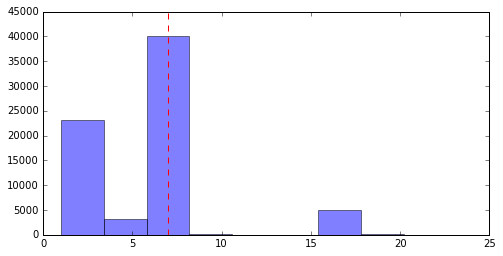

time_in_hospital
Unique values: 14
p-value: 0.0
Normal: False
Mean: 4.28913000923 std: 2.94918931791


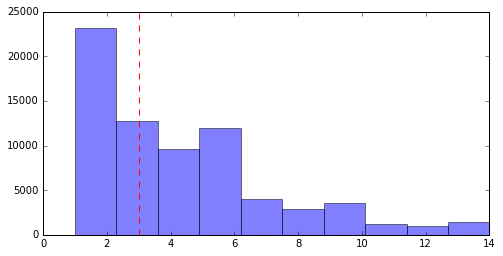

num_lab_procedures
Unique values: 116
p-value: 6.21468844265e-193
Normal: False
Mean: 43.0754775022 std: 19.9521984517


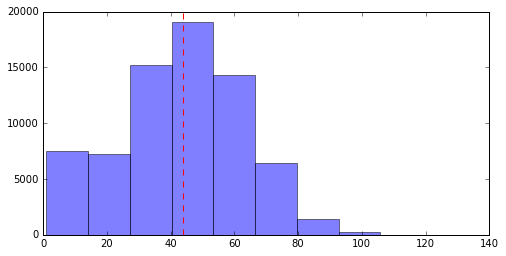

num_procedures
Unique values: 7
p-value: 0.0
Normal: False
Mean: 1.4305769177 std: 1.75985165854


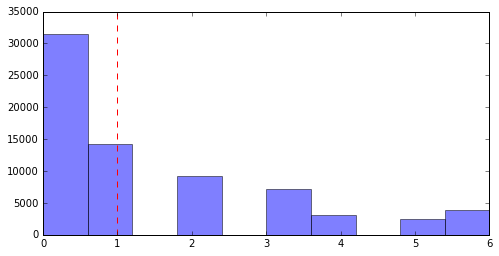

num_medications
Unique values: 75
p-value: 0.0
Normal: False
Mean: 15.7050253083 std: 8.31110460595


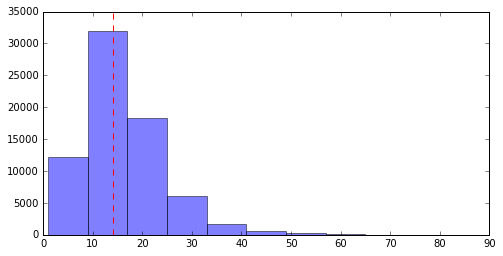

number_outpatient
Unique values: 33
p-value: 0.0
Normal: False
Mean: 0.28006935317 std: 1.06894918085


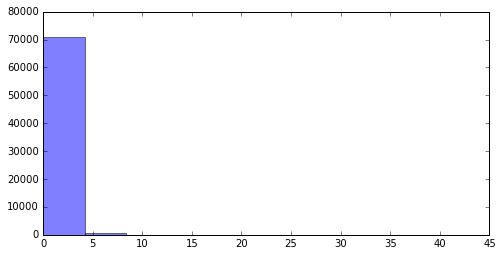

number_emergency
Unique values: 18
p-value: 0.0
Normal: False
Mean: 0.10354036746 std: 0.509183039153


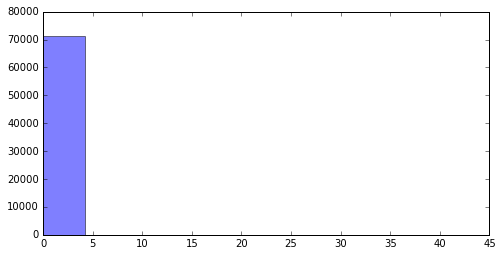

number_inpatient
Unique values: 13
p-value: 0.0
Normal: False
Mean: 0.177829357644 std: 0.603785311366


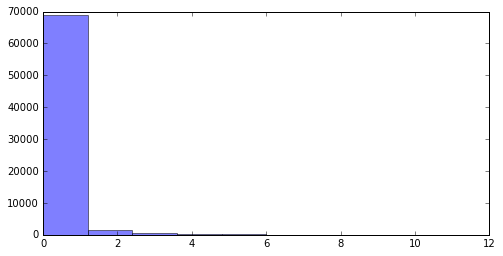

number_diagnoses
Unique values: 16
p-value: 0.0
Normal: False
Mean: 7.24570038312 std: 1.99466048358


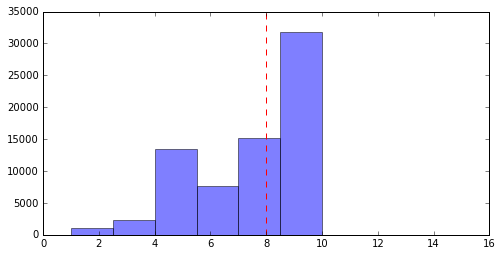

metformin
Unique values: 4
p-value: 0.0
Normal: False
Mean: 0.424858077687 std: 0.835632319895


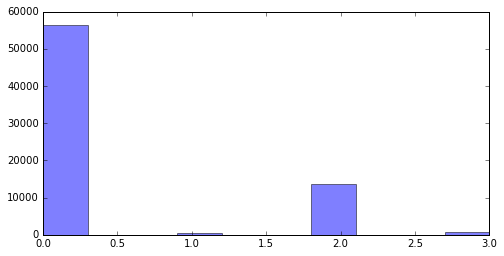

In [220]:
from scipy.stats import boxcox

for i,rv in enumerate(dfFiltered.columns[:-1]):

    #Compute data
    cleanIc = dfFiltered.iloc[:,i]
    
    if dfNorm[dfNorm.variable == rv][["categoric"]].values == "no":

        f_value, p_value = stats.normaltest(cleanIc)
    
        print rv
        print "Unique values:", len(np.unique(cleanIc))
        print "p-value:", p_value 
        print "Normal:", p_value >= 0.05
        print "Mean:", np.mean(cleanIc), "std:", np.std(cleanIc)
        
        plt.figure(figsize=(8,4))
        plt.hist(cleanIc, bins=10, alpha=0.5)
        plt.axvline(np.median(cleanIc), c="r", ls="--")
        plt.show()        

gender
(2,)
1.000    38023
0.000    33492
Name: gender, dtype: int64


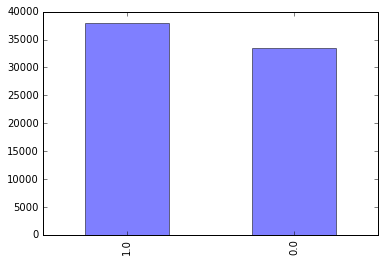

age
(10,)
7    18162
6    15908
5    12349
8    11864
4     6756
3     2650
9     2040
2     1111
1      525
0      153
Name: age, dtype: int64


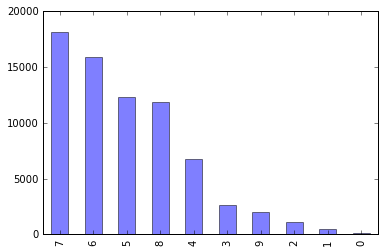

metformin
(4,)
0    56944
2    13347
3      798
1      429
Name: metformin, dtype: int64


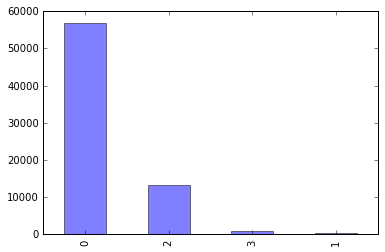

repaglinide
(4,)
0    70548
2      857
3       78
1       35
Name: repaglinide, dtype: int64


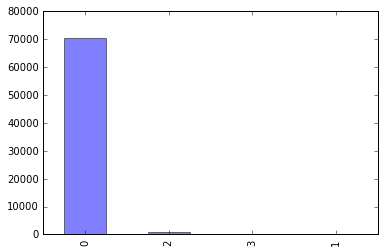

glimepiride
(4,)
0    67833
2     3306
3      242
1      137
Name: glimepiride, dtype: int64


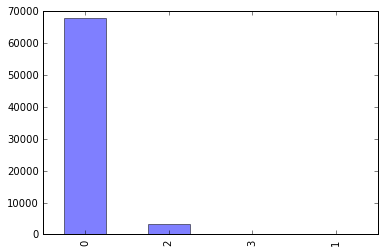

glipizide
(4,)
0    62711
2     7905
3      552
1      350
Name: glipizide, dtype: int64


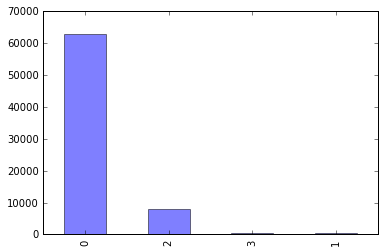

glyburide
(4,)
0    63989
2     6555
3      586
1      388
Name: glyburide, dtype: int64


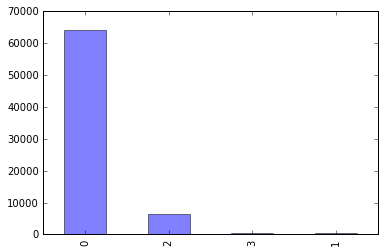

pioglitazone
(4,)
0    66308
2     4957
3      167
1       86
Name: pioglitazone, dtype: int64


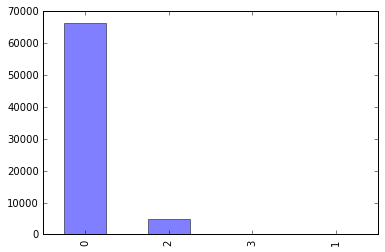

rosiglitazone
(4,)
0    67118
2     4197
3      133
1       70
Name: rosiglitazone, dtype: int64


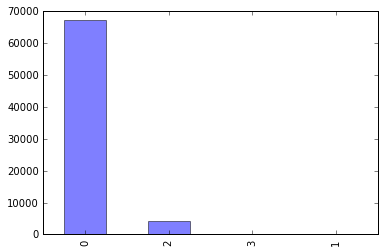

insulin
(4,)
0    34335
2    22247
1     7729
3     7207
Name: insulin, dtype: int64


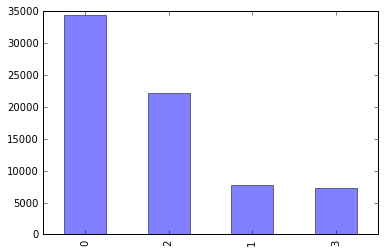

diabetesMed
(2,)
1    54196
0    17322
Name: diabetesMed, dtype: int64


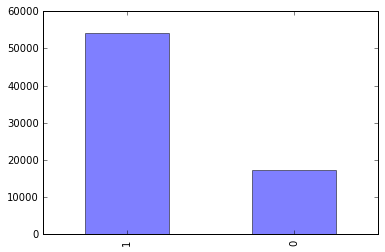

race_AfricanAmerican
(2,)
0    58602
1    12916
Name: race_AfricanAmerican, dtype: int64


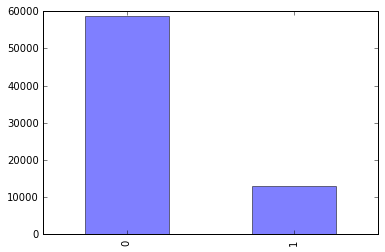

race_Asian
(2,)
0    71006
1      512
Name: race_Asian, dtype: int64


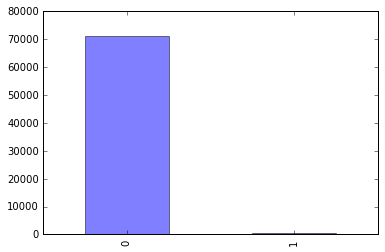

race_Caucasian
(2,)
1    53556
0    17962
Name: race_Caucasian, dtype: int64


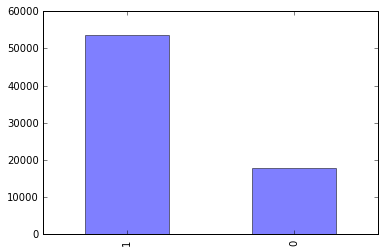

race_Hispanic
(2,)
0    70004
1     1514
Name: race_Hispanic, dtype: int64


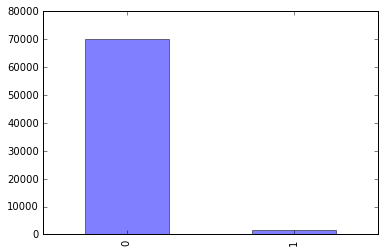

race_Other
(2,)
0    70348
1     1170
Name: race_Other, dtype: int64


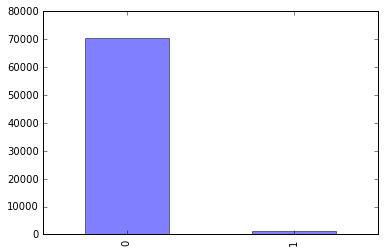

race_nan
(2,)
0    69668
1     1850
Name: race_nan, dtype: int64


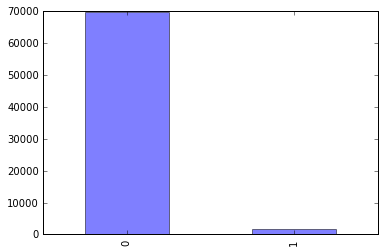

In [195]:
#Categorical
for i,rv in enumerate(dfFiltered.columns[:-1]):

    #Compute data
    cleanIc = dfFiltered.iloc[:,i]
    
    if dfNorm[dfNorm.variable == rv][["categoric"]].values == "yes":
                
        print rv
        print pd.value_counts(cleanIc).shape
        print pd.value_counts(cleanIc)
        pd.value_counts(cleanIc).plot(kind="bar", alpha=0.5)
        plt.show()